In [1]:
import gmsh_utils
import importlib
importlib.reload(gmsh_utils)
from gmsh_utils import *
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

### load in crater data and contour data for z = 1100 m

In [2]:
ventdatafile='../data/VentGeometryData.mat'
vd = scipy.io.loadmat(ventdatafile)
contourdatafile='../data/Contour1100.mat'
c1100 = scipy.io.loadmat(contourdatafile)

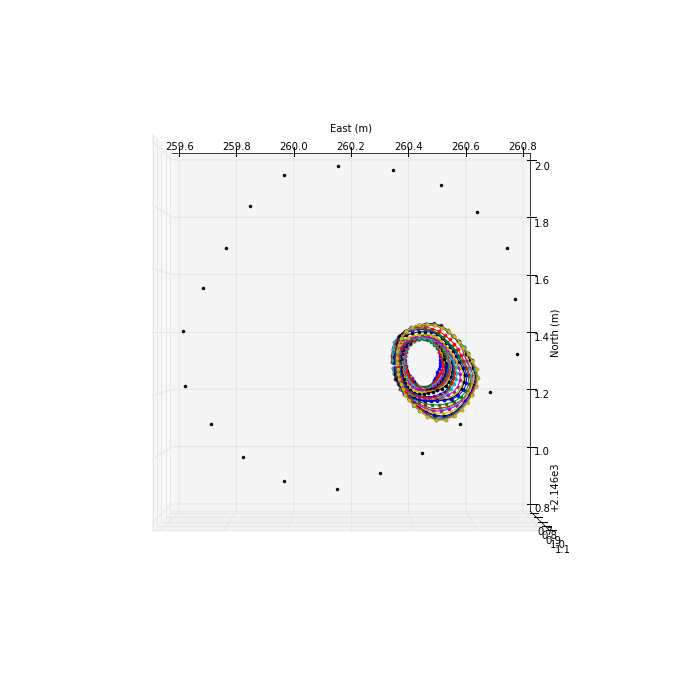

In [3]:
# overlook crater/vent geometry data
zs_v   = np.array(vd['zs'][0], dtype=float)
pt_v    = [i[0] for i in vd['points']]

# the contour for z = 1100.
x1100 = c1100['x']
y1100 = c1100['y']

fig = plt.figure(figsize=(12,12))
ax  = fig.gca(projection='3d',aspect='equal')
for pt in pt_v:
    ax.plot(pt[:,0]/1000,pt[:,1]/1000, pt[:,2]/1000,'.-')
    ax.view_init(elev= 90, azim= -90)
plt.xlabel('East (m)')
plt.ylabel('North (m)')
ax.plot(x1100[::20]/1000, y1100[::20]/1000, 1.1,'.')

### Build mesh
#### A 300 meter deep Overlook crater inside another ~80 m deep Halemaumau crater and flat outside surrounding.
#### A lava lake surface is inserted into the Overlook crater

In [4]:
geofile = 'KilaueaCrater.geo' 
zs    = zs_v[::3]  # every 30 meters a level
pts   = pt_v[::3]  # each contains the xy coordinates of points
zlake = 1000
x_lake= 2.604584249773606e+05
y_lake= 2.147270125870880e+06
L  = 2000.
# meshsize
size_c = 20
size_o = 50
size_b = 100

# downsample the 1100 contour
skip   = 10

# outter crater top and bottom z
z_o_bt = 1030
z_o_tp = 1100

In [5]:
Point.reset_index()
Line.reset_index()
LineLoop.reset_index()
Surface.reset_index()
SurfaceLoop.reset_index()
Volume.reset_index()
Field.reset_index()


# nlevel of points
N  = len(zs)

# index of the lava lake level
iz_lake = np.argmin(np.abs(zs-zlake))

objs = []

# create all the points for the Overlook crater
points = []
for pt in pts:
    pts_level_i = []
    for p in pt:
        x,y,z = p
        pi = Point(x-x_lake, y-y_lake, z, size_c)
        pts_level_i.append(pi)
    points.append(pts_level_i)

for p in points:
    objs += p

lines_h         = [] # horizontal lines
lines_v         = [] # vertical lines

for iLevel in range(N):
    pts_level_i = points[iLevel]
    
    n = len(pts_level_i)
    
    # create horizontal lines
    lines_level_i = []
    for i in range(n):
        start = pts_level_i[i]
        if i<n-1:
            end = pts_level_i[i+1]
        else:
            end = pts_level_i[0]
        line_i = Line(start, end)
        lines_level_i.append(line_i)
    lines_h.append(lines_level_i)
    
    # vertical vertical lines
    if iLevel==N-1:
        continue
    
    lines_level_i = []
    pts_level_j = points[iLevel+1]
    for i in range(n):
        start = pts_level_i[i]
        end   = pts_level_j[i]
        line_i = Line(start, end)
        lines_level_i.append(line_i)
    
    lines_v.append(lines_level_i)

for l in lines_v + lines_h:
    objs += l

# create line loops
lineloops_sides = [] # side line loops
surfaces_sides  = [] # side surfaces

for iLevel in range(N-1):
    lines_h_ib = lines_h[iLevel]
    lines_h_it = lines_h[iLevel+1]
    lines_v_i  = lines_v[iLevel]
    
    n = len(lines_h[iLevel])
    lineloops_iLevel = []
    surfaces_iLevel  = []
    
    for i in range(n):
        if i<n-1:
            line_list = [lines_h_ib[i], lines_v_i[i+1], lines_h_it[i], lines_v_i[i]]
        else:
            line_list = [lines_h_ib[i], lines_v_i[0], lines_h_it[i], lines_v_i[i]]
        lineloop_i = LineLoop(line_list)
        lineloops_iLevel.append(lineloop_i)
        surface_i  = Surface([lineloop_i])
        surfaces_iLevel.append(surface_i)
    
    lineloops_sides.append(lineloops_iLevel)
    surfaces_sides.append(surfaces_iLevel)

for i in lineloops_sides + surfaces_sides:
    objs += i

# create horizontal surfaces
lineloop_bt   = LineLoop(lines_h[0])
surface_bt    = Surface([lineloop_bt], isPlaneSurface=True)

lineloop_lake = LineLoop(lines_h[iz_lake])
surface_lake    = Surface([lineloop_lake], isPlaneSurface=True)

lineloop_tp   = LineLoop(lines_h[-1])
# surface_tp    = Surface([lineloop_tp], isPlaneSurface=True)

objs += [lineloop_bt, lineloop_lake, lineloop_tp, 
         surface_bt, surface_lake]

# create surface loops
surfacelist_bt = [surface_bt, surface_lake]
for i in range(iz_lake):
    surfacelist_bt += surfaces_sides[i]

surfaceloop_bt = SurfaceLoop(surfacelist_bt)
volume_bt  = Volume([surfaceloop_bt])
objs += [surfaceloop_bt]
objs += [volume_bt]

surfacelist_tp = [surface_lake]

for i in range(iz_lake, N-1):
    surfacelist_tp += surfaces_sides[i]

# create another cylinder geometry for Halemaumau crater/ the outside crater
# with bottom at z=1030, top at z=1100.

# create points
xs = c1100['x'][::skip]
ys = c1100['y'][::skip]

points_m_o = []
points_p_o = []
lines_m_o  = []
lines_p_o  = []
lines_v_o  = []
lineloops_side_o = []
surfaces_side_o  = []

for (x, y) in zip(xs, ys):
    pm = Point(x-x_lake, y-y_lake, z_o_bt, size_o)
    pp = Point(x-x_lake, y-y_lake, z_o_tp, size_o)
    
    points_m_o.append(pm)
    points_p_o.append(pp)
    lines_v_o.append(Line(pm, pp))

N = len(points_m_o)
for i in range(N):
    if i<N-1:
        lm = Line(points_m_o[i], points_m_o[i+1])
        lp = Line(points_p_o[i], points_p_o[i+1])
    else:
        lm = Line(points_m_o[i], points_m_o[0])
        lp = Line(points_p_o[i], points_p_o[0])
    
    lines_m_o.append(lm)
    lines_p_o.append(lp)
    
for i in range(N):
    if i<N-1:
        lloop = LineLoop([lines_m_o[i], lines_v_o[i+1], lines_p_o[i], lines_v_o[i]])
    else:
        lloop = LineLoop([lines_m_o[i], lines_v_o[0], lines_p_o[i], lines_v_o[i]])
    
    lineloops_side_o.append(lloop)
    si = Surface([lloop])
    surfaces_side_o.append(si)

objs += points_m_o + points_p_o + lines_m_o + lines_p_o + lines_v_o + lineloops_side_o + surfaces_side_o

# create outter crater bottom surface
lineloop_bt_o = LineLoop(lines_m_o)
surface_bt_o  = Surface([lineloop_bt_o, lineloop_tp], isPlaneSurface=True)

# create outter crater top surface
lineloop_tp_o = LineLoop(lines_p_o)

objs += [lineloop_bt_o , surface_bt_o , lineloop_tp_o]

# create a outside box

xs = np.array([-L, L, L, -L]) + x_lake
ys = np.array([-L, -L, L, L]) + y_lake

points_m_b = []
points_p_b = []
lines_m_b  = []
lines_p_b  = []
lines_v_b  = []
lineloops_side_b = []
surfaces_side_b  = []

for (x, y) in zip(xs, ys):
    pm = Point(x-x_lake, y-y_lake, z_o_tp-L, size_b)
    pp = Point(x-x_lake, y-y_lake, z_o_tp, size_b)
    
    points_m_b.append(pm)
    points_p_b.append(pp)
    lines_v_b.append(Line(pm, pp))

N = len(points_m_b)
for i in range(N):
    if i<N-1:
        lm = Line(points_m_b[i], points_m_b[i+1])
        lp = Line(points_p_b[i], points_p_b[i+1])
    else:
        lm = Line(points_m_b[i], points_m_b[0])
        lp = Line(points_p_b[i], points_p_b[0])
    
    lines_m_b.append(lm)
    lines_p_b.append(lp)
    
for i in range(N):
    if i<N-1:
        lloop = LineLoop([lines_m_b[i], lines_v_b[i+1], lines_p_b[i], lines_v_b[i]])
    else:
        lloop = LineLoop([lines_m_b[i], lines_v_b[0], lines_p_b[i], lines_v_b[i]])
    
    lineloops_side_b.append(lloop)
    si = Surface([lloop])
    surfaces_side_b.append(si)

objs += points_m_b + points_p_b + lines_m_b + lines_p_b + lines_v_b + lineloops_side_b + surfaces_side_b

# bottom and and top surfaces of the outside box.
lineloop_bt_b = LineLoop(lines_m_b)
surface_bt_b  = Surface([lineloop_bt_b], isPlaneSurface=True)

# create outter crater top surface
lineloop_tp_b = LineLoop(lines_p_b)
surface_tp_b  = Surface([lineloop_tp_b, lineloop_tp_o], isPlaneSurface=True)
objs += [lineloop_bt_b , surface_bt_b , lineloop_tp_b, surface_tp_b]


# create air chamber surface loop, outter crater and top part of the inner crater
surfaces_list   = [surface_bt, surface_bt_o] + surfaces_side_o

for s in surfaces_sides:
    surfaces_list += s

# surface loop for outter box
surfaces_list += [surface_bt_b, surface_tp_b] + surfaces_side_b

surfaceloop_b = SurfaceLoop(surfaces_list)
objs += [surfaceloop_b]

# create a volume that contains outer box with a hole
volume_solid = Volume([surfaceloop_b])
objs += [volume_solid]
    
if geofile:
    f = open(geofile, 'w')
    for obj in objs:
        f.write(obj.write_txt())
    f.close()